<a href="https://colab.research.google.com/github/paganpasta/eqxvision/blob/documentation%2Fgetting_started%2Fself-attention/docs/getting_started/vit_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT: Self-Attention Maps

In this tutorial we will take a look at how we can use a pre-trained ViT
and visualise the self-attention maps from the last layer. 

The content here is quite straight-forward and most of it is based on 
[`facebookresearch/dino`](https://github.com/facebookresearch/dino). 

Some key steps we will be performing here:

- Preparing an input image with `torchvision` transforms.
- Loading a `ViT-base` with `pretrained=True`.
- Obtaining `self-attention` maps from the last layer of the network.
- Visualising the results.


### Installing Dependecy

In [1]:
!pip install -U eqxvision --quiet

     |████████████████████████████████| 66 kB 3.5 MB/s 


### Required Imports

In [18]:
import requests
from io import BytesIO

from torchvision import transforms
from PIL import Image

import equinox as eqx
import eqxvision.models as eqv_models
import jax
import jax.numpy as jnp
import jax.random as jr

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Query Image

In [65]:
#Download
response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
img = Image.open(BytesIO(response.content))
img = img.convert('RGB')

#Transform
transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
])
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

o_img = transform(img)  # Used for visualisation
t_img = normalize(o_img)  # Used for inference

### Initializing model

As mentioned before, we are loading up a `vit-base` with default parameters.
Take a look at the documentation if you are not sure what these parameters are.

We also change the network over to the `inference` mode. This ensures that various layers such as `DropPath` or `Dropout` behave as expected.

In [66]:
model = eqv_models.vit_base(num_classes=0, pretrained=True)
model = eqx.tree_inference(model, True)

#Required by models in forward pass.
key = jr.PRNGKey(0)

### Expected attention map size 

The attention map size will be `patch_size` $\times$ `patch_size`. 

In [23]:
_, img_h, img_w = t_img.shape
h_featmap = img_h // model.patch_embed.patch_size[0]
w_featmap = img_w // model.patch_embed.patch_size[1]

### Reshaping attentions maps

We are only interested in visualising the output corresponding to `cls_token`.
For this, simply pick the output at `index=0` and reshape it to the expected size as computed above.


In [24]:
attentions = model.get_last_self_attention(jnp.asarray(t_img.numpy()), key=key)
number_heads = attentions.shape[1]
print('Number of attention heads:', number_heads)
cls_attention = attentions[0, :, 0, 1:].reshape(number_heads, h_featmap, w_featmap)
print(f'Self attention maps: {cls_attention.shape[0]} x {cls_attention.shape[1]} x {cls_attention.shape[2]}')

Number of attention heads: 12
Self attention maps: 12 x 14 x 14


### Scaling attention maps

To visualise the attention maps overlaid on the input image, we need to resize the maps with some interpolation. Here we use `cubic` interpolation.

In [25]:
resized_maps = jax.image.resize(cls_attention, shape=[number_heads]+list(t_img.shape[1:]), method='cubic')
print(f'Resized maps: {resized_maps.shape}')

Resized maps: (12, 224, 224)


### Visualising self-attention maps 

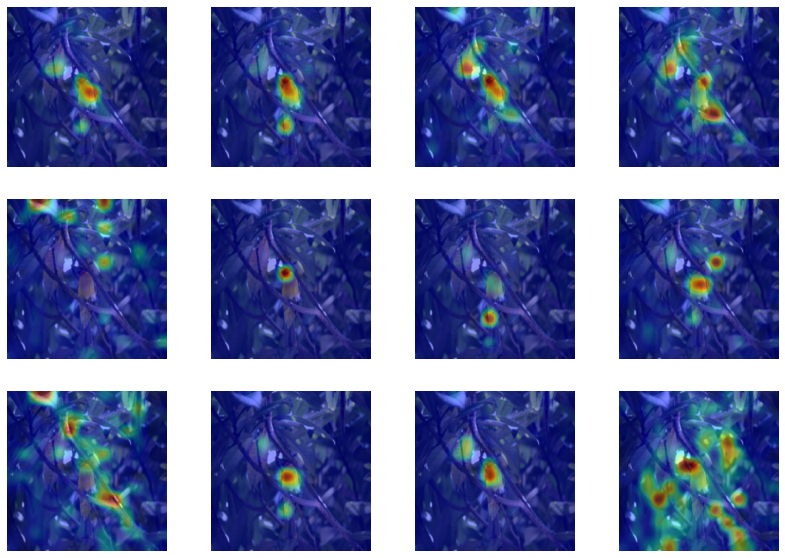

In [67]:
images_per_row = 4
number_rows = number_heads // images_per_row

fig = plt.figure(figsize=(14, 10))

for i in range(number_heads):
  fig.add_subplot(number_rows, images_per_row, i+1)
  plt.imshow(o_img.permute(1,2,0).numpy())
  plt.imshow(resized_maps[i], cmap='jet', alpha=0.4)
  plt.axis('off')
  plt.grid(b=None)
plt.show()

### *That's all Folks*